# A Deep Dive into Logisitc Classifier Models
## Comparing Linear, RBF, MAP and Laplace Approximation Techniques

In this notebook we will be looking at how a linear logisitc classifier model, an RBF model and a Laplacian approximation to a full Bayesian approach fair on calssifying some toy non-linearly separated two class data. This notebook will go through a data-driven approach to comparing the different techniques.

In [1]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from tqdm.notebook import trange, tqdm


/Users/liamkristoffy/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.random.seed(seed=0)

The first step is to load the toy data. The data has been so chosen to give a very non-linear decision bourndary to compare linear and radial basis function logisitic regression.

In [3]:
#Load data
X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')


Next we will perform EDA by creating a function to plot the data points, coloured by their respective class label.

In [4]:
def plot_data_internal(X, y):
    '''
    Function that plots the points in 2D together with their labels

    parameters
    ----------
    X: 2d array with the input features
    y: 1d array with the class labels (0 or 1)

    returns
    -------
    xx, yy: 2D matrices with the x and y coordinates of the points shown in the plot

    '''


    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure(figsize=(10,10))
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)

    #Reeturns to later be used with plot_predictive_distribution function
    return xx, yy

def plot_data(X, y):
    '''
    Function that plots the data without returning anything by calling "plot_data_internal".

    parameters
    ----------
    X: 2d array with the input features
    y: 1d array with the class labels (0 or 1)

    returns
    -------
    None

    '''
    _, _ = plot_data_internal(X, y)
    plt.show()

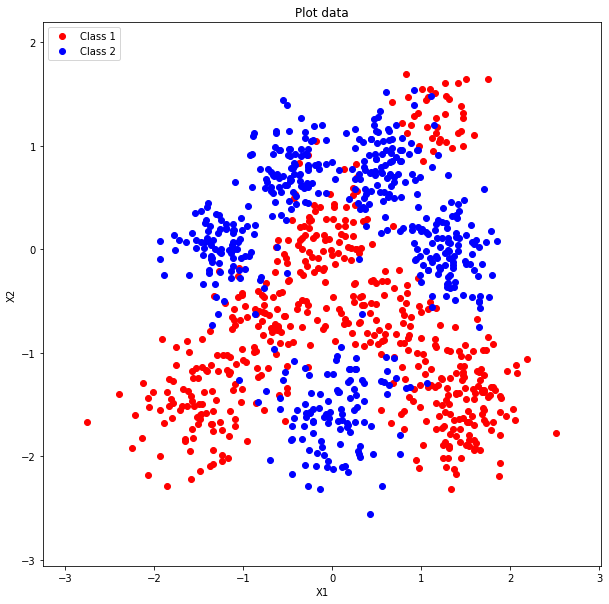

In [5]:
#Call plotting function
plot_data(X, y)

By plotting the 2 dimensional data, we can see that the desicion boundary between the two classes is highly non-linear.

In the following sections we will fit a MLE logisitc regression classifier from first principles. 
A lgisitic regression classifier uses the logisitc function, along with gradient descent to try and fit the logisitc function to the data by minimising the log-liklihood.

The logistic function takes the form as seen below:
$$ \sigma(x) = \frac{1}{1 + \exp(-x)} $$
and can be seen in python code below.

In [6]:
# The logistic function

def logistic(x): return 1.0 / (1.0 + np.exp(-x))

To start working with the data we need to add a constant term to the training data to add a bias term to the logisitc regression classifier.

This will convert $X$ to $\~{X}$ (X tilde) with a concatenated 1 term to the $X$ features.

In [7]:


def get_x_tilde(X): 
    '''
    Function that expands a matrix of input features by adding a column equal to 1.
    
    parameters
    ----------
    X: matrix of input features.
    
    returns
    -------
    Matrix x_tilde with one additional constant column equal to 1 added.
    
    '''

    return np.concatenate((np.ones((X.shape[ 0 ], 1 )), X), 1)

For our logisitc regression classifier we also need a method for predicting the probability of a class given a set of data points $\~X$ and model weights $w$. This can be done with the equation:
$$ p(\~X) = \frac{1}{1 + \exp(-w^T \~X)} = \sigma(w^T \~X)$$
and can be seen in a function below.

In [8]:
def predict(X_tilde, w): 
    '''
    Function that makes predictions with a logistic classifier
    
    parameters
    ----------
    X_tile: matrix of input features (with a constant 1 appended to the left) for which to make predictions
    w: vector of model parameters
    returns
    -------
    The predictions of the logistic classifier
    '''
    
    
    return logistic(np.dot(X_tilde, w))

Next we need a method for evaluating the model on a data set. We will use the average log liklihood, where the liklihood for observation $i$, with label $t^{(i)}$ is:
$$ \mathcal{l}(x^{(i)}) = t^{(i)} \log(\sigma(w^T \~X)) + (1-t^{(i)}) \log(1 - \sigma(w^T \~X))$$

and we take the average over all observations to get average log liklihood ($\mathcal{L}$) as seen below:

In [9]:
def compute_average_ll(X_tilde, y, w):
    '''
    Function that computes the average loglikelihood of the logistic classifier on some data.

     parameters
    ----------
    X_tile: matrix of input features (with a constant 1 appended to the left) for which to make predictions
    y: vector of binary output labels 
    w: vector of model parameters


    returns
    -------
    Average logliklihood 
    '''
    output_prob = predict(X_tilde, w)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))

To optimise the model paramters to training data, we need a fitting function that updates the model parameters $w$.
The update rule for these parameters will use vanilla gradient descent:
$$ w \rightarrow w + \mu \frac{\partial \mathcal{L}}{\partial w}$$
where $\mu$ is the learning rate hyperparameter and the derivative of log-liklihood $\frac{\partial \mathcal{L}}{\partial w}$ can be shown to be:
$$\frac{\partial \mathcal{L}}{\partial w} = \sum_{n} \~x^{(n)}(t^{(n)} - \sigma(w^T \~x^{(n)})) = \~X^T (t - \sigma(w^T \~X))

In [10]:
def fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha):
    '''
    Function that finds the model parameters by optimising the likelihood using gradient descent

    parameters
    ----------
    X_tile_train: matrix of training input features (with a constant 1 appended to the left) 
    y_train: vector of training binary output labels
    X_tile_test: matrix of test input features (with a constant 1 appended to the left) 
    y_test: vector of test binary output labels 
    alpha: step_size_parameter for the gradient based optimisation
    n_steps: the number of steps of gradient based optimisation


    returns
    -------
    w: Vector of model parameters
    ll_train: Vector with average log-likelihood values obtained on the training set
    ll_test: Vector with average log-likelihood values obtained on the test set
    '''


    w = np.random.randn(X_tilde_train.shape[ 1 ])
    ll_train = np.zeros(n_steps)
    ll_test = np.zeros(n_steps)
    for i in range(n_steps):
        sigmoid_value = predict(X_tilde_train, w)
        w = w + alpha * ((X_tilde_train.T).dot(y_train - sigmoid_value))
        ll_train[ i ] = compute_average_ll(X_tilde_train, y_train, w)
        ll_test[ i ] = compute_average_ll(X_tilde_test, y_test, w)
        if i == n_steps-1:
            print(ll_train[ i ], ll_test[ i ])

    return w, ll_train, ll_test

Let's use our newly made functions to fit on the data with a random learning rate and number of iterations, first partioning our data into test and train

In [11]:
permutation = np.random.permutation(X.shape[ 0 ])
X_p = X[ permutation, : ]
y_p = y[ permutation ]

n_train = int(X_p.shape[0] * 0.8)
X_train = X_p[ 0 : n_train, : ]
X_test = X_p[ n_train :, : ]
y_train = y_p[ 0 : n_train ]
y_test = y_p[ n_train : ]

X_tilde_train = get_x_tilde(X_train)
X_tilde_test = get_x_tilde(X_test)



In [12]:
print(X_train.shape)
print(X_tilde_train.shape)

print(X_test.shape)
print(X_tilde_test.shape)

(800, 2)
(800, 3)
(200, 2)
(200, 3)


In [13]:
alpha = 0.005
n_steps = 300

w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

-0.6146423847523887 -0.6615175404130907


To visualise the learning, lets plot the loglikelihood as a funciton of iteration

In [14]:
def plot_ll(ll):
    '''
    Function that plots the average log-likelihood returned by "fit_w"

    parameters
    ----------
    ll: vector with log-likelihood values


    returns
    -------
    None
    '''
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.xlim(0, len(ll) + 2)
    plt.ylim(min(ll) - 0.1, max(ll) + 0.1)
    ax.plot(np.arange(1, len(ll) + 1), ll, 'r-')
    plt.xlabel('Steps')
    plt.ylabel('Average log-likelihood')
    plt.title('Plot Average Log-likelihood Curve')
    plt.show()

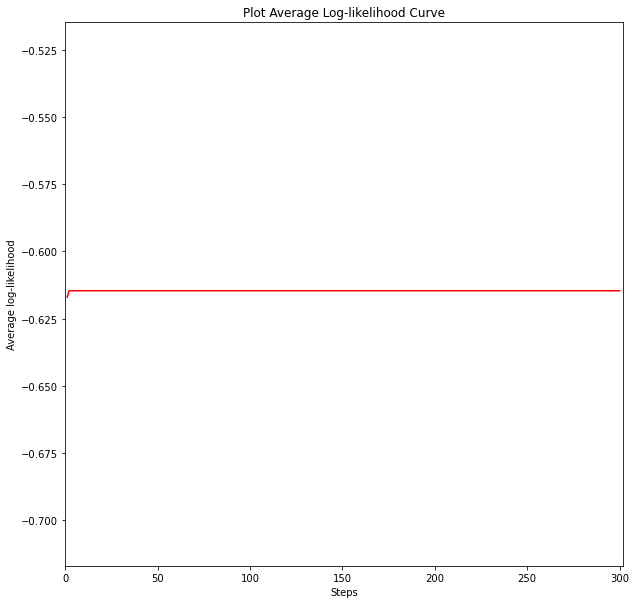

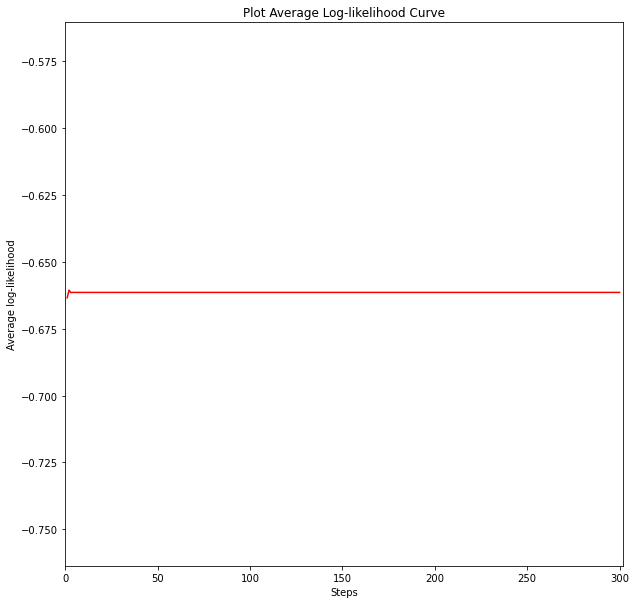

In [15]:
# We plot the training and test log likelihoods

plot_ll(ll_train)
plot_ll(ll_test)

Let's look at the confusion matrix to see how well our model is doing at classifying the data points.

In [16]:
def get_conf_matrix(X_tilde_test, y_test, w, threshold=0.5):    
    '''
    Function that returns the confusion matrix for MLE

    parameters
    ----------
    X_tile_test: matrix of test input features (with a constant 1 appended to the left) 
    y_test: vector of test binary output labels 
    w: vector of trained parameters
    threshold: output threshold of model to be classified as class 1, standard is 0.5


    returns
    -------
    C: confusion matrix
    '''
    Z = predict(X_tilde_test, w)
    y_predict = np.ones(len(Z))
    for i in range(len(Z)):
        if Z[i] > threshold:
            y_predict[i] = 1
        else:
            y_predict[i] = 0

    C11=0
    C12=0
    C21=0
    C22=0
    for i in range(len(y_predict)):
        if y_test[i] == 0 and y_predict[i] == 0:
            C11+=1
        elif y_test[i] == 0 and y_predict[i] == 1:
            C12+=1
        elif y_test[i] == 1 and y_predict[i] == 0:
            C21+=1
        elif y_test[i] == 1 and y_predict[i] == 1:
            C22+=1
        else:
            print('uh oh')
    
    C = np.array([[C11, C12], [C21, C22]])/Z.shape[0]
    

    return C

In [17]:
C = get_conf_matrix(X_tilde_test, y_test, w)
print(C)
print("-"*15)
print(f"Accuracy: {C[0][0]+C[1][1]:.3f}")

[[0.345 0.17 ]
 [0.15  0.335]]
---------------
Accuracy: 0.680


The learning curves seem to plateau very quickly, to a suboptimal loglikelihood, and our model has an accuray that is not much better than randomly guessing!

What is going on?

Let's visualise the predicitive distribution with the data points.

In [18]:
def plot_predictive_distribution(X, y, w, map_inputs = lambda x : x):
    '''
    Function that plots the predictive probabilities of the logistic classifier

    parameters
    ----------
    X: 2d array with the input features for the data (without adding a constant column with ones at the beginning)
    y: 1d array with the class labels (0 or 1) for the data
    w: parameter vector
    map_inputs: function that expands the original 2D inputs using basis functions.


    returns
    -------
    None
    '''
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predict(X_tilde, w)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

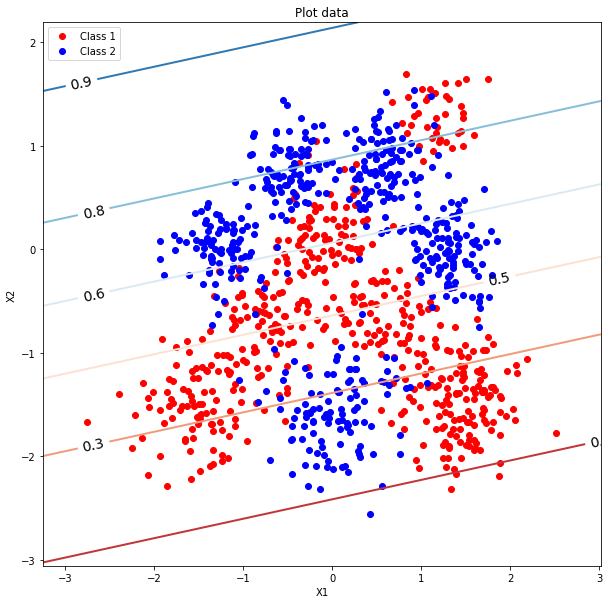

In [19]:
# We plot the predictive distribution

plot_predictive_distribution(X, y, w)

## Adding RBFs to the Linear Logisitc Classifier Model

We are trying to fit a linear desicion boundary to a very non-linear dataset! We need something else to fit the non-linear data.

This is where we can use a basis function to add non-linear features to our linear classifier, creating a non-linear desicion boundary. For this experiment we will use the popular Gaussian basis function with the equation:
$$ \phi (x_1,x_2) = \exp (-\frac{1}{2 l^2 } ||x_1 - x_2||_2)$$

where $l$ is the length scale hyperparameter and $||.||_2$ denotes euclidian distance. We will use all the training data points as the basis function centers.


In [20]:

def evaluate_basis_functions(l, X, Z):
    '''
    Function that replaces initial input features by evaluating Gaussian basis functions
    on a grid of points

    parameters
    ----------
    l: hyper-parameter for the width of the Gaussian basis functions
    Z: location of the Gaussian basis functions
    X: points at which to evaluate the basis functions


    returns
    -------
    Feature matrix with the evaluations of the Gaussian basis functions.
    '''

    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

In [21]:
print(X.shape)

(1000, 2)


In [22]:
from sklearn.gaussian_process.kernels import RBF


In [23]:
print(np.log(0))

-inf


/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/2955966184.py:1: RuntimeWarning: divide by zero encountered in log
  print(np.log(0))


-0.1520531206118724 -0.46614173415633586


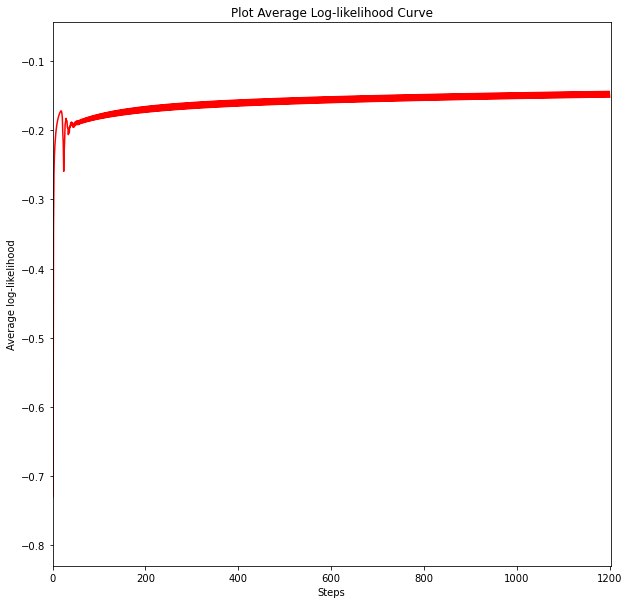

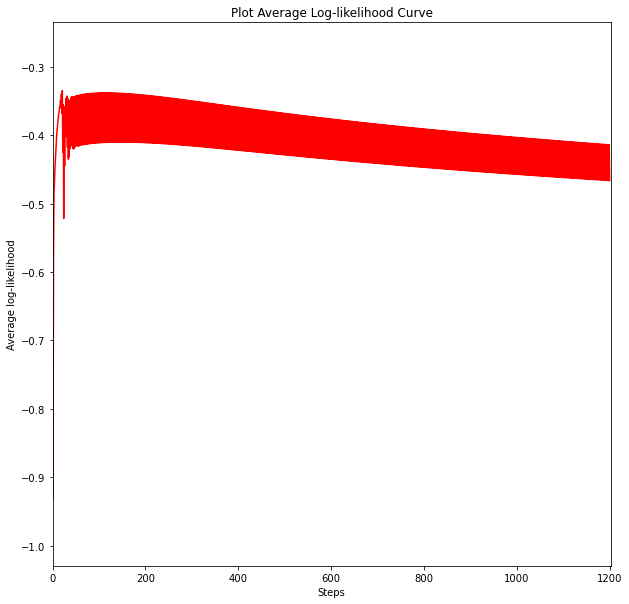

In [24]:
# We expand the data

l = 0.29

X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

# We train the new classifier on the feature expanded inputs

alpha = 0.02
n_steps = 1200

w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

# We plot the training and test log likelihoods

plot_ll(ll_train)
plot_ll(ll_test)

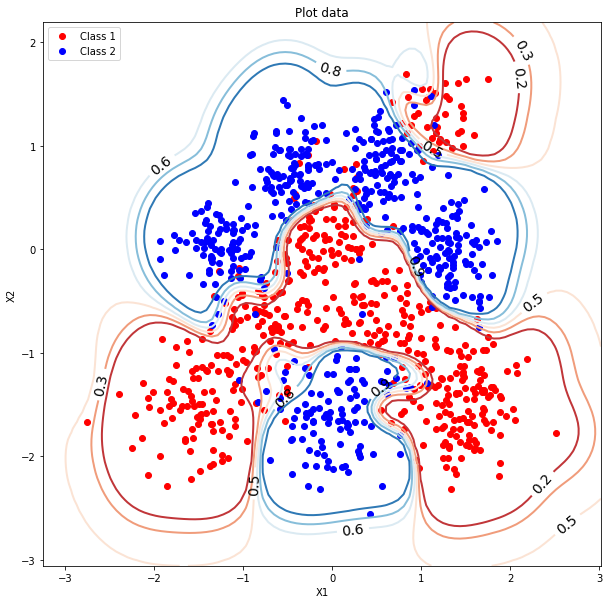

[[0.44  0.075]
 [0.03  0.455]]
---------------
Accuracy: 0.895


In [25]:
# We plot the predictive distribution

plot_predictive_distribution(X, y, w, lambda x : evaluate_basis_functions(l, x, X_train))
C = get_conf_matrix(X_tilde_test, y_test, w)
print(C)
print("-"*15)
print(f"Accuracy: {C[0][0]+C[1][1]}")

Looks promising... but why is the log-liklihood oscillating at the minima? Let's try to fix this.

## Adding Momentum to Gradient Descent

There are a few options, for instance reducing the learning rate, but we will look at adding momentum to the vanilla gradient descent with the equation below:

![title](image/momentum.png)

In [26]:
def fit_w_mom(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha, beta=0.2):
    '''
    Function that finds the model parameters by optimising the likelihood using gradient descent with added momentum to the gradient descent

    parameters
    ----------
    X_tile_train: matrix of training input features (with a constant 1 appended to the left) 
    y_train: vector of training binary output labels
    X_tile_test: matrix of test input features (with a constant 1 appended to the left) 
    y_test: vector of test binary output labels 
    alpha: step_size_parameter for the gradient based optimisation
    beta: the momentum factor (the fraction of the learning rate that is past values)
    n_steps: the number of steps of gradient based optimisation


    returns
    -------
    w: Vector of model parameters
    ll_train: Vector with average log-likelihood values obtained on the training set
    ll_test: Vector with average log-likelihood values obtained on the test set
    '''

    
    w = np.random.randn(X_tilde_train.shape[ 1 ])
    ll_train = np.zeros(n_steps)
    ll_test = np.zeros(n_steps)
    v = 0
    for i in range(n_steps):
        sigmoid_value = predict(X_tilde_train, w)
        v = beta * v + (1-beta) * ((X_tilde_train.T).dot(y_train - sigmoid_value))
        
        w = w + alpha * v
        ll_train[ i ] = compute_average_ll(X_tilde_train, y_train, w)
        ll_test[ i ] = compute_average_ll(X_tilde_test, y_test, w)
        if i == n_steps-1:
            print(ll_train[ i ], ll_test[ i ])

    return w, ll_train, ll_test

-0.11900451826392637 -0.39586826837794453


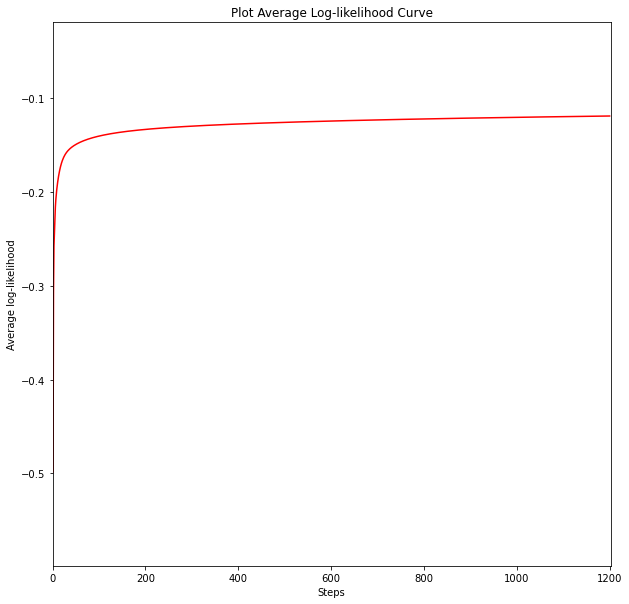

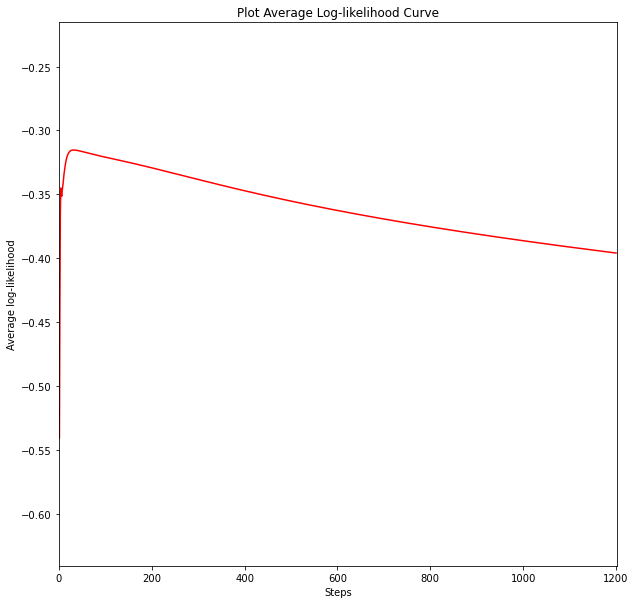

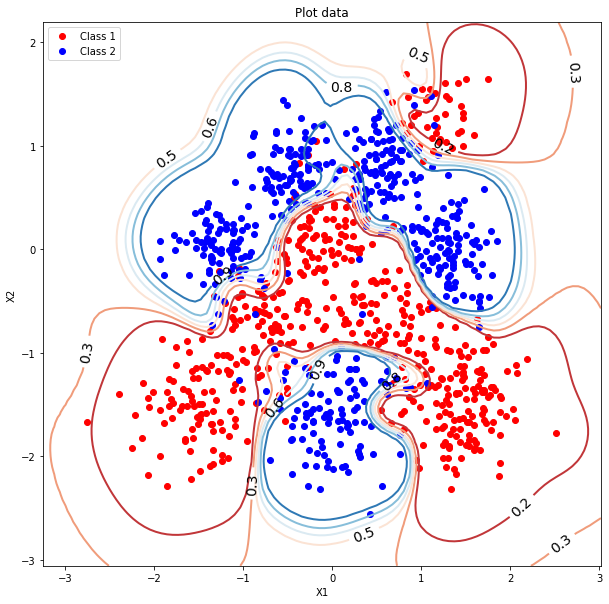

[[0.47  0.045]
 [0.05  0.435]]
---------------
Accuracy: 0.905


In [27]:


w, ll_train, ll_test = fit_w_mom(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha, beta=0.3)

# We plot the training and test log likelihoods

plot_ll(ll_train)
plot_ll(ll_test)

# We plot the predictive distribution

plot_predictive_distribution(X, y, w, lambda x : evaluate_basis_functions(l, x, X_train))
C = get_conf_matrix(X_tilde_test, y_test, w)
print(C)
print("-"*15)
print(f"Accuracy: {C[0][0]+C[1][1]}")

## MLE Hyperparameter Tuning

This has obviously performed MUCH better than the linear logistic regression model, the log-likelihood for both the training and test data is higher and the accuracy of the model is at 0.905 -- an improvement of 33% on the linear model. As well as this, the momentum has smoothed out the oscillations of the log-likelihood of the vailla gradient descent with RBF logisitc regression and improved the accuracy. 

However, we have just guessed the hyper-parameters of the learning rate and the length scale parameter, let's make a function to tune these hyper-parameters... (we are not going to tune the momentum parameter $\beta$ for simplicity)

Note: there also seems to be problems with over-fitting as can be seen by the peaking and then later reduction of the test log-likelihood but we will deal with this later.

In [28]:


def get_ll_test_mom(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha, beta=0.3):
    '''
    Function that fits parameters to training data and outputs the log-likelihood for the test data. Used for hyperparameter tuning function

    parameters
    ----------
    X_tile_train: matrix of training input features (with a constant 1 appended to the left) 
    y_train: vector of training binary output labels
    X_tile_test: matrix of test input features (with a constant 1 appended to the left) 
    y_test: vector of test binary output labels 
    alpha: step_size_parameter for the gradient based optimisation
    beta: the momentum factor (the fraction of the learning rate that is past values)
    n_steps: the number of steps of gradient based optimisation


    returns
    -------
    ll_test: Vector with average log-likelihood values obtained on the test set
    '''
     
    w = np.random.randn(X_tilde_train.shape[ 1 ])
    v = 0
    for i in range(n_steps):
        sigmoid_value = predict(X_tilde_train, w)
        v = beta * v + (1-beta) * ((X_tilde_train.T).dot(y_train - sigmoid_value))
        
        w = w + alpha * v

        if i == n_steps-1:
            #ll_train = compute_average_ll(X_tilde_train, y_train, w)
            ll_test = compute_average_ll(X_tilde_test, y_test, w)
            return ll_test


def tune_parameters_MLE(X_train, y_train, X_test, y_test, alpha , l, beta=0.3):
    '''
    Function that finds the hyperparamter values that maximises the log-likelihood of the test data

    parameters
    ----------
    X_train: matrix of training data
    y_train: vector of training binary output labels
    X_test: matrix of test data
    y_test: vector of test binary output labels 
    alpha: vector of step_size_parameter for the gradient based optimisation
    l: vector of length scale parameter
    beta: the momentum factor (the fraction of the learning rate that is past values)


    returns
    -------
    ll_array: array of log-likelihood of test data
    max_ll_test: max log-likelihood of test data
    max_ind: indices of max log-likelihood
    '''
    
    n_steps = 400
    max_ll_test = -float('inf')
    max_ind = [0,0]

    
    ll_array = np.ones((alpha.shape[0], l.shape[0])) # test likelihood
    for j in tqdm(range(l.shape[0])):
        X_tilde_train = get_x_tilde(evaluate_basis_functions(l[j], X_train, X_train))
        X_tilde_test = get_x_tilde(evaluate_basis_functions(l[j], X_test, X_train))
        for i in range(alpha.shape[0]):


            ll_test = get_ll_test_mom(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha[i], beta)
            #print(ll_test)
            if max_ll_test<ll_test and ll_test!=float('inf'): #Second check is to naively deal with overflow
                max_ll_test=ll_test
                max_ind=[i,j]

            ll_array[i][j] = ll_test

    
    return ll_array, max_ll_test, max_ind



In [33]:
alpha_l = np.linspace(0.001, 1, 60)
l_l = np.linspace(0.001, 0.4, 60) 

ll_array, max_ll_test, max_ind = tune_parameters_MLE(X_train, y_train, X_test, y_test, alpha_l, l_l)

  0%|          | 0/60 [00:00<?, ?it/s]

/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/1531468630.py:17: RuntimeWarning: divide by zero encountered in log
  return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))
/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/1531468630.py:17: RuntimeWarning: invalid value encountered in multiply
  return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))
/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/1569366233.py:3: RuntimeWarning: overflow encountered in exp
  def logistic(x): return 1.0 / (1.0 + np.exp(-x))


In [34]:
print(f"Max log evidence: {max_ll_test:.2f}")
print(f"Max learning rate: {alpha_l[max_ind[0]]:.3}")
print(f"Max length scale: {l_l[max_ind[1]]:.3}")

Max log evidence: -0.26
Max learning rate: 0.001
Max length scale: 0.265


-0.14869515484524357 -0.3148552498226904


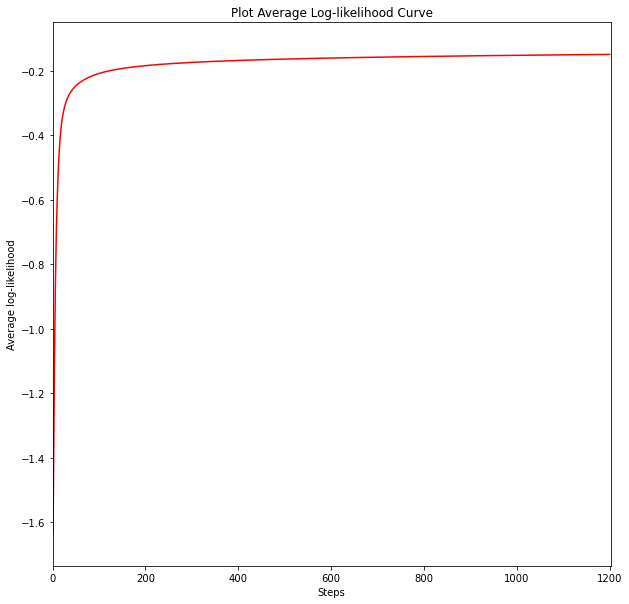

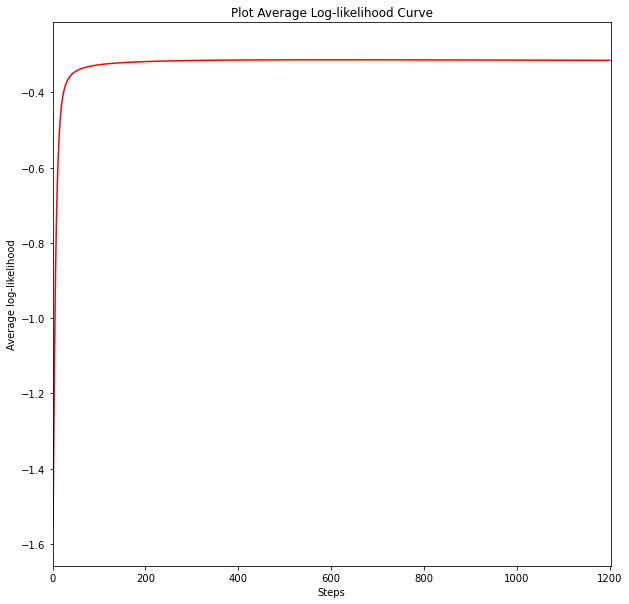

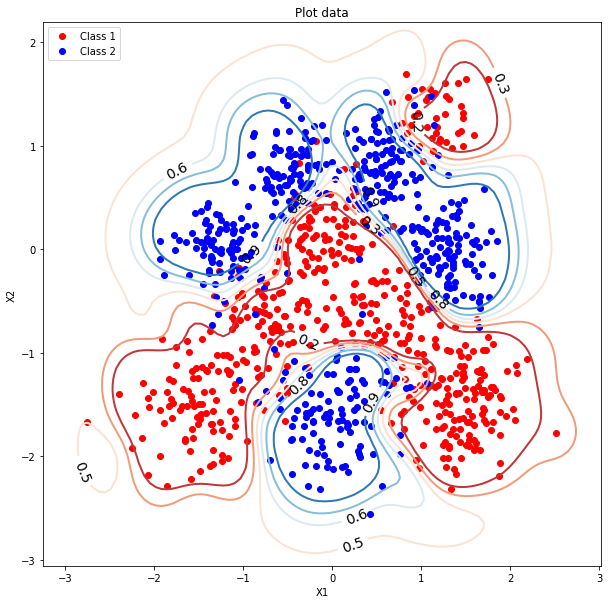

[[0.46  0.055]
 [0.045 0.44 ]]
---------------
Accuracy:  0.9


In [39]:
w, ll_train, ll_test = fit_w_mom(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha_l[max_ind[0]], beta=0.35)

# We plot the training and test log likelihoods

plot_ll(ll_train)
plot_ll(ll_test)

# We plot the predictive distribution

plot_predictive_distribution(X, y, w, lambda x : evaluate_basis_functions(l_l[max_ind[1]], x, X_train))
C = get_conf_matrix(X_tilde_test, y_test, w)
print(C)
print("-"*15)
print(f"Accuracy: {C[0][0]+C[1][1]: .3}")

Tuning the hyperparameters for MLE over the likelihood has slightly decreseased the accuracy, hm. What else can we do?

Looking at the predictive distribution, the model still seems to be overfitting and the model is very confident in it's predicitons (as seen by the steep decision boundaries). 

How do we fix this? Queue Bayesian inference...

## Bayesian Approach to RBF Logisitc Regression

We have looked at MLE approximation of the RBF logisitic regression weights, now it is time to look at a fully Bayesian approach, of the form:

$$p(w|\mathcal{D}) = \frac{p(\mathcal{D}|w)p(w)}{p(\mathcal{D})}$$

where $w$ is a vector of the model parameters and $\mathcal{D}$ denotes the data of two dimensional feature vectors and targets.

This will not only give us a distribution over the model parameters, which is a good way of quantifying uncertainty, but also is equivalent to L2 regulariztion of the model parameters, as can be seen from the log-posterior used in gradient descent.

The problem is that the exact fully Bayesian inference for logistic regression is intractable, and thus we need to use a method called Laplace approximation that uses a Guassian distribution centered on the functions mode to approximate the posterior distribution.

First we need to find the mode of the posterior distribution, which is equivelent to finding the MAP solution of the posterior.

For this, we will assume a Guassian prior on the weights:
$$p(w) = \mathcal{N}(w| 0, S_N)$$

We update the model weights to maximise the log-posterior:
$$ -\mathcal{L} = ln(p(w|\mathcal{D})) = -\frac{1}{2}w^T S_{0} w + \sum_{i=1}^N (t^{(i)} \log(\sigma(w^T \~X)) + (1-t^{(i)}) \log(1 - \sigma(w^T \~X)))$$

The loss function of the Maximum A Priori point estimation shows us that this method for finding the weights $w$, is equivalent to MLE estimation with an added regularisation term $-\frac{1}{2}w^T S_{0}^{-1} w$ for the weight prior distribution. Thus it can be seen that this ie equivalent to L2 regularisation of the model paramters and will help stop over-fitting of the model.

To update the weights we will use the gradient descent using the derivative of the log-posterior as follows:
$$ -\frac{\partial \mathcal{L}}{\partial w} = \~X^T (t - \sigma(w^T \~X)) - w^T S_0 $$

Thus to obtain a Gaussian approximation to the posterior distribution, we first maximize the posterior distribution to give the MAP (maximum posterior) solution $w_{MAP}$, which defines the mean of the Gaussian in the Laplace approximation.

In [40]:

def compute_lpost(X_tilde, y, w, var_0):
    '''Function that returns the log-posterior probabolity for the model weights and the gradient of the log-posterior. Used for finding MAP solution of the model parameters'''
    output_prob = predict(X_tilde, w)
    S0_1 = 1/var_0 * np.identity(w.shape[0])
    lpost = np.sum(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob)) - 0.5 * (w.T).dot(S0_1).dot(w)
    lpost_grad = (X_tilde.T).dot(y - output_prob) - S0_1.dot(w)
    return lpost, lpost_grad

In [41]:
def get_MAP(X_tilde, y, var_0):
    '''Function that returns MAP solution for the model weights and the value of the log-posterior probability at the MAP solution'''
    
    def objective(w):
        obj, obj_grad = compute_lpost(X_tilde, y, w, var_0)
        return -obj, -obj_grad
    w0 = np.random.randn(X_tilde.shape[ 1 ])
    w_MAP, ln_n_f_w_MAP, opt_dcit = scipy.optimize.fmin_l_bfgs_b(objective, w0)
    return w_MAP, ln_n_f_w_MAP

In [42]:
var_0 = 1
w_MAP, f_w_map = get_MAP(X_tilde_train, y_train, var_0)

In [43]:
print(w_MAP)

[-0.34565089 -0.16284954 -0.01455662  0.12609414 -0.27256827  0.00267981
  0.07922765  0.18620689 -0.25014498  0.05804537 -0.17247653 -0.1188528
  0.19894387  0.10906717  0.07848102 -0.0178857   0.24096268  0.21804426
  0.14758525 -0.21384225  0.1597881   0.38464433 -0.37638056 -0.0814473
 -0.11472394 -0.27482175  0.15287955  0.13780108  0.08581987  0.00262105
  0.13807102 -0.30087532 -0.19613719 -0.13012559  0.13284856 -0.31607612
  0.07028888  0.02409687 -0.38589281  0.09472267 -0.01838076 -0.17345302
 -0.11315854 -0.08704823 -0.10817196  0.27123194 -0.02198341  0.21775458
  0.16102932 -0.2212237  -0.07249527  0.23269348  0.12933093  0.27020045
 -0.07529947  0.28280103  0.1505368   0.27726444 -0.04539759 -0.10570851
  0.11496309 -0.2329956   0.205285    0.01934933  0.11252298 -0.00350807
 -0.15121639  0.03665087 -0.0005572   0.31485442  0.08221069  0.19617153
  0.04743625  0.23498757  0.17814181  0.24957724  0.21170775 -0.21006012
 -0.09234994  0.21902164  0.04205114  0.14056189  0.1

Then the covariance can be found with the inverse of the matrix of second derivatives of the negative log likelihood, which takes the form: 
$$ S_N = - \nabla \nabla ln(p(w|t))= S_{0}^{-1} + \sum_{n=1}^{N} y_n(1-y_n) \phi_{n} \phi_{n}^T $$

In [44]:
print(X_tilde_train.shape)

(800, 801)


In [45]:
def get_S_N(X_tilde, w, var_0):
    '''
    function that finds the covariance matrix of the approximated posterior Gaussian distribution of the model parameters

    params
    ------
    X_tilde: array-like of shape (n_samples, n_features)
    w: vector of trained model paramters
    var_0: prior on the variance of the model parameters

    returns
    -------
    S_N: numpy array of covariance matrix of shape (n_features, n_features)
    '''
    S_N = np.linalg.inv(var_0 * np.identity(len(w)))
    yn = logistic(np.dot(X_tilde, w))
    for i in range(X_tilde.shape[0]):
        S_N += yn[i] * (1.0 - yn[i]) * np.outer(X_tilde[i,:], X_tilde[i,:])
    
    return S_N


In [46]:
S_N = get_S_N(X_tilde_train, w_MAP, var_0)

In [47]:
print(w_MAP.shape)
print(S_N.shape)

(801,)
(801, 801)


We now have a Guassian approximation to the posterior, of the form:

$$ q(w) = \mathcal{N} ( w | w_{MAP}, S_N ) $$

Let's visualise some of the weight's distributions.

In [48]:
import seaborn as sns
import pandas as pd

#cov = np.dot(cov, cov.T)  # To ensure it's positive semi-definite

# Generate random samples
samples = np.random.multivariate_normal(w_MAP, S_N, size=10000)

# Convert to DataFrame for easier plotting
df = pd.DataFrame(samples, columns=[f'Dim {i}' for i in range(801)])


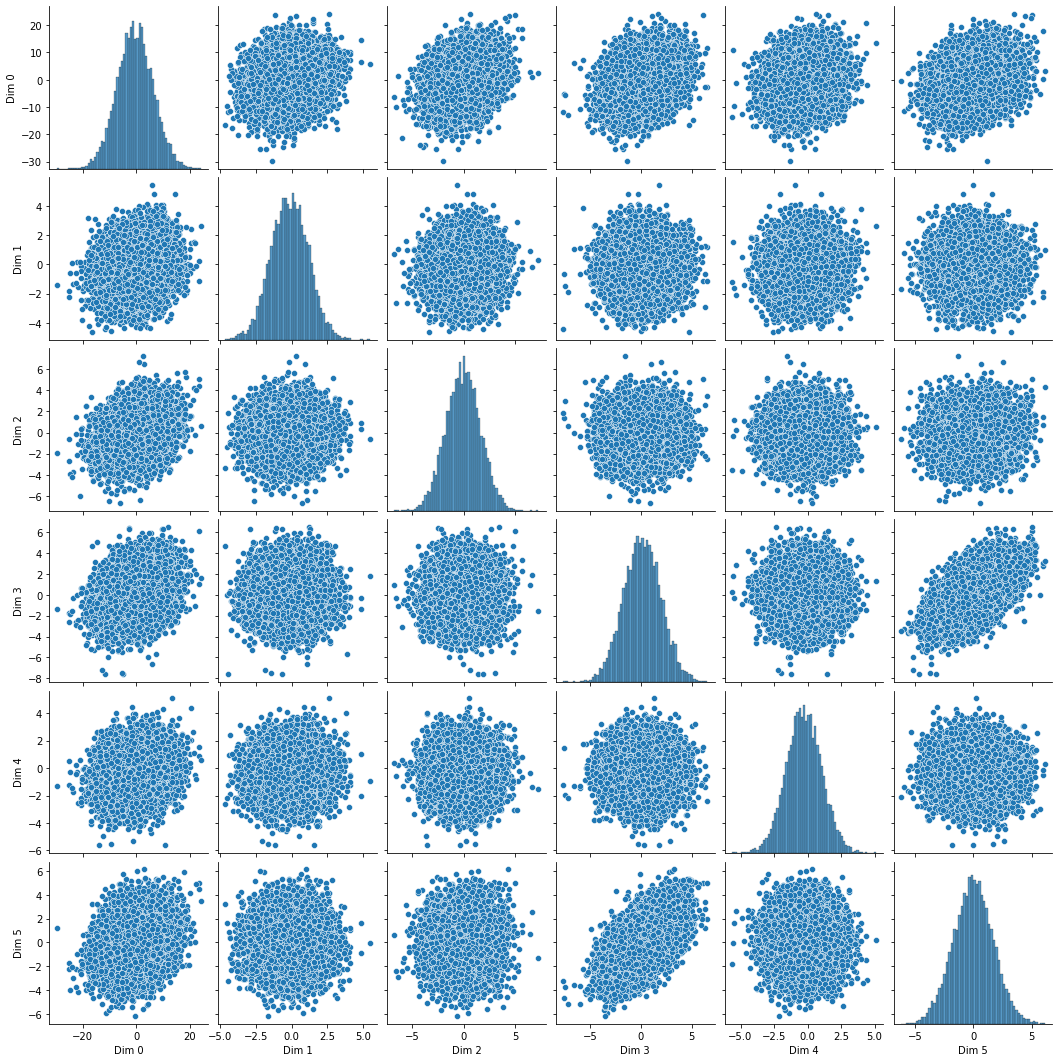

In [49]:
# Pairplot of the first few dimensions
sns.pairplot(df.iloc[:, 0:6])  
plt.show()

## Bayesian Predicitve Distribution

Now that we have an approximate distribution for the posterior to the model weights, we need to find the predictive distribution of the model. The predictive distribution for class $\mathcal{C}_1$, given a new feature vector $\phi (x)$, is obtained by marginalising with respect to the posterior distribution $p(w|t)$, which is itself approximated by a Gaussian distribution $q(w)$ so that:

$$ p(\mathcal{C}_1 | \phi, t) = \int p(\mathcal{C}_1 | \phi, w) p(w|t) dw \simeq \int \sigma(w^T \phi) q(w) dw $$

Denoting $a = w^T \phi$, it can be shown that:
$$ \int \sigma(w^T \phi) q(w) dw  = \int \sigma(a) p(a) da$$

where 
$$p(a) = \int \delta(a - w^T \phi) q(w) dw $$

Because $q(w)$ is Guassian, we know the marginal will be Guassian and thus we can find the mean and covariance using moments to get:

$$\mu_a = w_{MAP}^T \phi$$

$$ \sigma_{a}^2 = \phi^T S_N \phi $$

Thus our variational approximation to the predictive distribution becomes:

$$ p(\mathcal{C}_1 | t) = \int \sigma(a)p(a) da = \int \sigma(a) \mathcal{N}(a|\mu_a, \sigma_a^2) da $$

The integral over "$a$" represents the convolution of a Gaussian with a logistic sigmoid, and cannot be evaluated analytically. We can however make a close approximation using a probit function $\phi(x)$ instead of a sigmoid $\sigma(x)$, which allows us to express the integral analytically. This will give us the approximation:

$$ \int \sigma(a) \mathcal{N}(a|\mu, \sigma^2) da \simeq \sigma(\kappa(\sigma^2)\mu) $$

where

$$\kappa(\sigma^2) = (1+\pi \sigma^2 / 8)^{-1/2} $$

This gives us the approximate final form of the predictive distribution:

$$ p(\mathcal{C}_1 | \phi, t) = \sigma(\kappa(\sigma_a^2)\mu_a) $$

Let's implement this...

In [50]:
def kapa(sigma): return (1 + ((np.pi * sigma**2) / 8)) ** (-0.5)

In [51]:

def predict_bey(X_tilde, w, var_0):
    '''
    Function that makes predictions with a Bayesian Logisitc Classifier Model
    
    parameters
    ----------
    X_tile: matrix of input features (with a constant 1 appended to the left) for which to make predictions
    w: vector of MAP model parameters
    var_0: prior model parameter variance

    returns
    -------
    The predictions of the Bayesian Logisitc Classifier Model
    '''
    mu_a = X_tilde.dot(w)

    S_N = get_S_N(X_tilde, w, var_0)

    var_a = np.diag((X_tilde).dot(S_N).dot(X_tilde.T))
    
    Z = logistic(mu_a * kapa(var_a))

    return Z

Let's find this predicitve distribution and plot...

In [52]:
def plot_bey_predictive_distribution(X, y, w, var_0, map_inputs = lambda x : x):
    '''
    Function that plots the predictive probabilities of the logistic classifier for Bayesian

    parameters
    ----------
    X: 2d array with the input features for the data (without adding a constant column with ones at the beginning)
    y: 1d array with the class labels (0 or 1) for the data
    w: parameter vector
    map_inputs: function that expands the original 2D inputs using basis functions.


    returns
    -------
    None
    '''

    xx, yy = plot_data_internal(X, y)
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    ax = plt.gca()
    Z = predict_bey(X_tilde, w, var_0) 
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.savefig("Bay_Contours_NonOpt.png", bbox_inches='tight')
    plt.show()

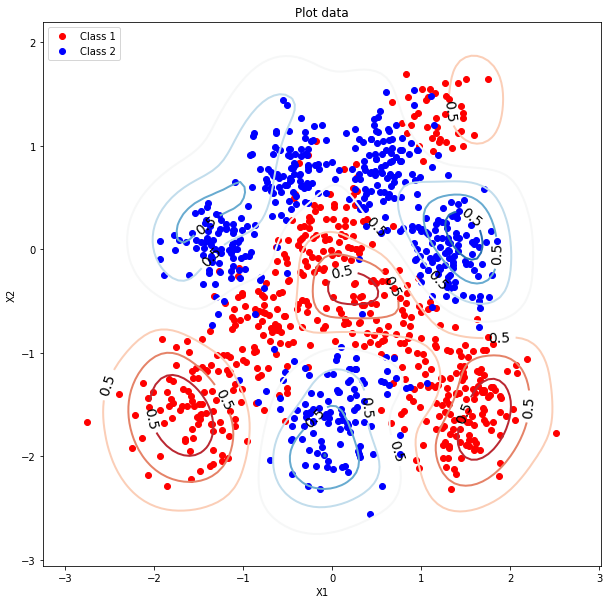

In [53]:
plot_bey_predictive_distribution(X, y, w_MAP, var_0, lambda x : evaluate_basis_functions(l, x, X_train))


In [54]:
def get__bey_conf_matrix(X_tilde_test, y_test, w, var_0, threshold=0.5):
    '''
    Function that returns the confusion matrix for MAP

    parameters
    ----------
    X_tile_test: matrix of test input features (with a constant 1 appended to the left) 
    y_test: vector of test binary output labels 
    w: vector of trained parameters
    threshold: output threshold of model to be classified as class 1, standard is 0.5


    returns
    -------
    C: confusion matrix
    '''
    
    Z = predict_bey(X_tilde_test, w, var_0)
    
    y_predict = np.ones(len(Z))
    for i in range(len(Z)):
        if Z[i] > threshold:
            y_predict[i] = 1
        else:
            y_predict[i] = 0

    C11=0
    C12=0
    C21=0
    C22=0
    for i in range(len(y_predict)):
        if y_test[i] == 0 and y_predict[i] == 0:
            C11+=1
        elif y_test[i] == 0 and y_predict[i] == 1:
            C12+=1
        elif y_test[i] == 1 and y_predict[i] == 0:
            C21+=1
        elif y_test[i] == 1 and y_predict[i] == 1:
            C22+=1
        else:
            print('uh oh')
    
    C = np.array([[C11, C12], [C21, C22]])/Z.shape[0]
    

    return C

In [55]:
C = get__bey_conf_matrix(X_tilde_test, y_test,w_MAP, var_0, threshold=0.5)
print(C)
print("-"*15)
print(f"Accuracy: {C[0][0]+C[1][1]}")

[[0.465 0.05 ]
 [0.045 0.44 ]]
---------------
Accuracy: 0.905


This has given us a model that has a nice looking decision boundary that is less over-confident (smoother decision boundaries), less over-fit to the data and an improved accuracy for the test data. However, we have again just guessed the hyper-parameters, let's try to fix this with hyper-parameter tuning...

## Bayesian Hyperparameter Tuning

We have got our new bayesian model perfoming well, but we have just guessed the hyperparamters $l$ and $S_0$. Now let's create a function to tune our hyperparameter.

Note we are assuming:
$$ S_0 = \sigma_0 I $$

To find the best hyperparamter values we will maximise the log of the model evidence ($p(\mathcal{D})$). When we use Laplace approximation, this can be shown to be approximately:
$$ ln(p(\mathcal{D})) \simeq ln(p(\mathcal{D} | w_{MAP})) + ln(p(w_{MAP})) + \frac{M}{2}ln(2 \pi) - \frac{1}{2}ln |S_N | $$

where $M$ is the number of model parameters and $|.|$ denotes the determinant of a matrix.

Let's implement this...

In [56]:
def compute_average_ll_bey(X_tilde, y, w, var_0):
    output_prob = predict_bey(X_tilde, w, var_0)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))


def get_log_model_evidence(X_tilde,y,  w, var_0, f_w):
    '''Returns log model evidence of the input data, used for Bayesian hyperparamter tuning'''
    S_N = np.linalg.inv(var_0 * np.identity(len(w)))
    for i in range(X_tilde.shape[0]):
        yn = logistic(np.dot(X_tilde[i,:], w))
        S_N += yn * (1.0 - yn) * np.outer(X_tilde[i,:], X_tilde[i,:])
    S_N_det = np.linalg.det(S_N)

    ln_pd = -f_w + (len(w)/2) * np.log(2 * np.pi) - 0.5 * np.log(S_N_det)
    
    #ln_pd = compute_average_ll_bey(X_tilde, y, w, var_0) + (len(w)/2) * np.log(X_tilde.shape[0])
    return ln_pd

We could create a parameter tuning function like we had before, making a grid of predefined values, but htis time let's try to make a random tuner that just takes the limits of the hyperparameters:

In [67]:
def tune_parameters_random(X_train, y_train, X_test, y_test, var_0_lims=[0.0001,1], l_lims=[0.0001,1], n=1000):
    '''
    Function that finds the hyperparamter values that maximises the log of model evidence of the test data

    parameters
    ----------
    X_train: matrix of training data
    y_train: vector of training binary output labels
    X_test: matrix of test data
    y_test: vector of test binary output labels 
    var_0_lims: limits of search range for prior variance on MAP
    l_lims: limits of search range for length scale hyperparameter
    beta: the momentum factor (the fraction of the learning rate that is past values)


    returns
    -------
    ll_array: array of log(model evidence) of test data
    max_ll_test: max log(model evidence) of test data
    max_ind: indices of max log(model evidence)
    '''
        
    var_0, l = np.random.uniform(low=var_0_lims[0], high=var_0_lims[1], size=n), np.random.uniform(low=l_lims[0], high=l_lims[1], size=n)
    Z_array = np.empty((n,n))
    max_ind = [0,0]
    max_Z = -float('inf')


    for i in tqdm(range(n)):
        X_tilde_train = get_x_tilde(evaluate_basis_functions(l[i], X_train, X_train))
        X_tilde_test = get_x_tilde(evaluate_basis_functions(l[i], X_test, X_train))
        w_MAP, f_w_MAP = get_MAP(X_tilde_train, y_train, var_0[i])
        Z = get_log_model_evidence(X_tilde_test, y_test, w_MAP, var_0[i], f_w_MAP)
        if Z>max_Z and Z != float('inf'): #naive method of dealing with overflow
            max_Z = Z
            max_ind = [i]

        Z_array[i]= Z

    '''for j in tqdm(range(l.shape[0])):
        X_tilde_train = get_x_tilde(evaluate_basis_functions(l[j], X_train, X_train))
        X_tilde_test = get_x_tilde(evaluate_basis_functions(l[j], X_test, X_train))
        for i in range(var_0.shape[0]):
            w_MAP, f_w_MAP = get_MAP(X_tilde_train, y_train, var_0[i])
            Z = get_log_model_evidence(X_tilde_test, y_test, w_MAP, var_0[i], f_w_MAP)
            if Z>max_Z and Z != float('inf'):
                max_Z = Z
                max_ind = [i,j]

            Z_array[j][i] = Z'''

    
    return var_0, l, Z_array, max_Z, max_ind




In [68]:
var_0_array, l_array, Z_array, max_Z, max_ind = tune_parameters_random(X_train, y_train, X_test, y_test, var_0_lims=[0.0001,3], l_lims=[0.0001,1.5], n=1000)
print(max_Z)
print(max_ind)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/liamkristoffy/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/975120790.py:5: RuntimeWarning: divide by zero encountered in log
  lpost = np.sum(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob)) - 0.5 * (w.T).dot(S0_1).dot(w)
/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/975120790.py:5: RuntimeWarning: invalid value encountered in multiply
  lpost = np.sum(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob)) - 0.5 * (w.T).dot(S0_1).dot(w)
/var/folders/hx/l5vvl9xj1lgg6tky6fl7m7sr0000gn/T/ipykernel_17634/1604356757.py:14: RuntimeWarning: divide by zero encountered in log
  ln_pd = -f_w + (len(w)/2) * np.log(2 * np.pi) - 0.5 * np.log(S_N_det)


978.5518825807676
[368]


In [69]:
print(f"Max log evidence: {max_Z:.2f}")
print(f"Max prior variance: {var_0_array[max_ind[0]]:.3}")
print(f"Max length scale: {l_array[max_ind[0]]:.3}")

Max log evidence: 978.55
Max prior variance: 2.73
Max length scale: 0.247


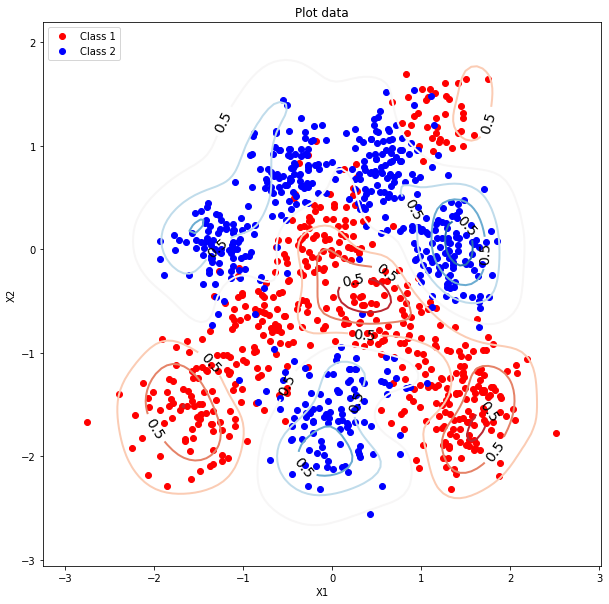

[[0.47  0.045]
 [0.045 0.44 ]]
---------------
Accuracy: 0.91


In [70]:
var_0_tuned = var_0_array[max_ind[0]]
l_tuned = l_array[max_ind[0]]
w_MAP_tuned, f_w_map_tuned = get_MAP(X_tilde_train, y_train, var_0_tuned)
plot_bey_predictive_distribution(X, y, w_MAP_tuned, var_0_tuned, lambda x : evaluate_basis_functions(l_tuned, x, X_train))

C = get__bey_conf_matrix(X_tilde_test, y_test,w_MAP_tuned, var_0_tuned, threshold=0.5)
print(C)
print("-"*15)
print(f"Accuracy: {C[0][0]+C[1][1]:.3}")


By tuning the hyperparameters we have got to an accuracy of 0.91. We have thus used a Laplace approximation to a fully Bayesian approach that has given us better accuracy than MLE, given us a distribution over the model parameters (good for quantifying uncertainty) and given us a model that is seemingly more cautious (smoother desicion boundaries) and less overfit to the data.